In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from core.models.hierarchical_transformer import HierarchicalTransformer
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from core.utils import create_transformer_dataset, generate_model_filename, TransformerLRScheduler
import numpy as np
import torch
import torch.nn as nn
import gc
import random
import os

In [3]:
seed = 69

def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

    # Set random seeds
    # os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Deterministic settings
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("Clean slate initialized!")

# Call this early in your notebook or script
initial_cleanup()

Clean slate initialized!


In [4]:
X_np, y_np, attention_masks_np, sequence_lengths_np = create_transformer_dataset(data_dir="../../data/keypoints",verbose=False)

Using max_frames = 200 (95.0th percentile)
Sequence length stats - Min: 0, Max: 404
Filtering out sample with length 236
Filtering out sample with length 236
Filtering out sample with length 267
Filtering out sample with length 267
Filtering out sample with length 237
Filtering out sample with length 237
Filtering out sample with length 248
Filtering out sample with length 248
Filtering out sample with length 207
Filtering out sample with length 207
Filtering out sample with length 219
Filtering out sample with length 219
Filtering out sample with length 280
Filtering out sample with length 280
Filtering out sample with length 249
Filtering out sample with length 249
Filtering out sample with length 247
Filtering out sample with length 247
Filtering out sample with length 210
Filtering out sample with length 210
Filtering out sample with length 215
Filtering out sample with length 215
Filtering out sample with length 283
Filtering out sample with length 283
Filtering out sample with le

In [5]:
# Convert to PyTorch tensors
X_np = X_np[:, :, :, :3]  # shape: (N, F, J, 3)
attention_masks_np = attention_masks_np  # shape: (N, F)

# First split: TrainVal vs Test
X_temp, X_test, y_temp, y_test, mask_temp, mask_test = train_test_split(
    X_np, y_np, attention_masks_np,
    test_size=0.1, random_state=seed, stratify=y_np
)

# Second split: Train vs Val
val_ratio = 0.1 / 0.9  # same as before
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_temp, y_temp, mask_temp,
    test_size=val_ratio, random_state=seed, stratify=y_temp
)

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

mask_train = torch.from_numpy(mask_train).float()
mask_val = torch.from_numpy(mask_val).float()
mask_test = torch.from_numpy(mask_test).float()

# Create datasets
train_dataset = TensorDataset(X_train, y_train, mask_train)
val_dataset = TensorDataset(X_val, y_val, mask_val)
test_dataset = TensorDataset(X_test, y_test, mask_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
htformer = HierarchicalTransformer(
    num_joints=33,
    num_frames=201,
    d_model=64,
    nhead=2,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

In [8]:
# Load the weights
# htformer.load_state_dict(torch.load("models/hierarchical_transformer_f201_d64_h2_s1_t1_do0.1_20250701_2251.pth", map_location=device))
htformer.load_state_dict(torch.load("../../models/final/hierarchical_transformer_f201_d64_h2_s1_t1_do0.1_20250701_1555.pth", map_location=device))

<All keys matched successfully>

In [9]:
# Switch to eval mode
htformer.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch, mask_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)

        # If your model uses the mask in forward()
        outputs = htformer(X_batch, mask_batch)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', 'shoulder_press'])
print(report)

d:\Thesis\thesis\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


                precision    recall  f1-score   support

        squats       0.92      1.00      0.96        85
     deadlifts       1.00      0.95      0.98        62
shoulder_press       1.00      0.94      0.97        65

      accuracy                           0.97       212
     macro avg       0.97      0.96      0.97       212
  weighted avg       0.97      0.97      0.97       212



[[85  0  0]
 [ 3 59  0]
 [ 4  0 61]]


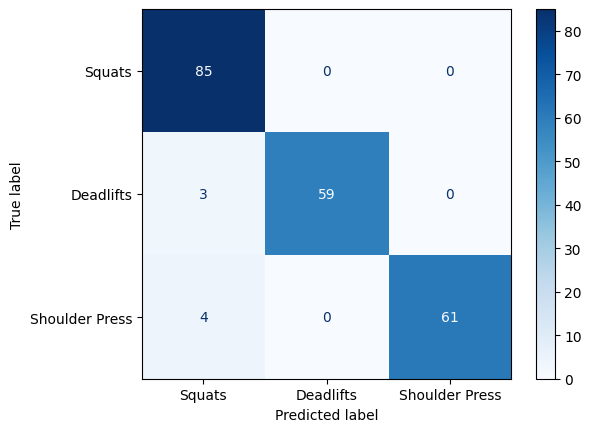

In [10]:
matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

ConfusionMatrixDisplay.from_predictions(all_labels, all_preds,
                                        display_labels=class_names,
                                        cmap='Blues')